In [1]:
# load edits to packages without restarting kernel
%load_ext autoreload
%autoreload 2

In [2]:
import harmonious_inference

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sbi
import scipy
import torch

In [3]:
np.random.seed(0)
torch.manual_seed(0)

# A simple harmonic oscillator

The package contains a class `PhysicsModel` that simulates a simple harmonic oscillator with equations of motion
\begin{equation}
    \frac{d^2x}{dt^2} = - \frac{k}{m} x,
\end{equation}
where $k$ is the spring constant and $m$ is the mass.
We are going to see if we can infer the values of $k$ and $m$ from time series for of the position and velocity.

We can initialise the class by specifying distributions from which it should draw initial conditions and the time values at which we want to know the position and velocity.  Also define `noise_amplitude` associated with measurement inaccuracy.

In [4]:
from harmonious_inference import PhysicsModel

x0_dist = scipy.stats.distributions.uniform(loc=-10., scale=20.)
v0_dist = scipy.stats.distributions.uniform(loc=-1., scale=2.)
t_eval = np.linspace(0, 10, 100)
noise_amplitude = 1e-2

linear_model = PhysicsModel(x0_dist, v0_dist, t_eval, noise_amplitude)

Let's also define ranges for $k$ and $m$ and prior probabilities for their values.

In [5]:
m_range = (1.0, 5.0)
k_range = (0.0, 10.0)
prior = sbi.utils.BoxUniform(low=torch.tensor([m_range[0], k_range[0], ]), high=torch.tensor([m_range[1], k_range[1], ]))

Plotting the output of the model in phase space, we see that the ratio of the maximum postion and velocity depend on $k/m$.

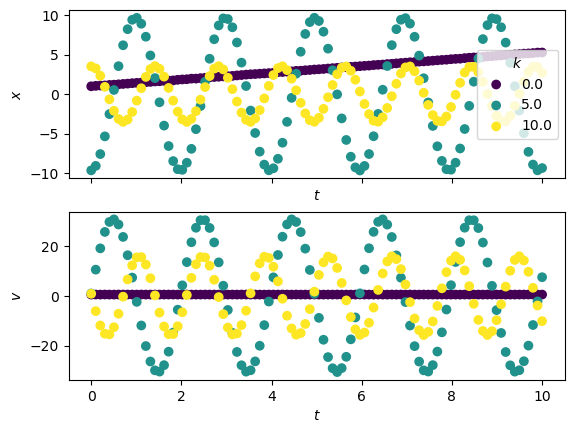

In [6]:
fig, [ax_x, ax_v] = plt.subplots(2, 1, sharex=True)

for k in np.linspace(*k_range, 3):
    d = linear_model.forward_model([1, k])

    ax_x.scatter(t_eval, d[0], c=[k for _ in d[0]], vmin=k_range[0], vmax=k_range[1], cmap=matplotlib.colormaps["viridis"], label=k)
    ax_v.scatter(t_eval, d[1], c=[k for _ in d[0]], vmin=k_range[0], vmax=k_range[1], cmap=matplotlib.colormaps["viridis"], label=k)
    
ax_x.set_xlabel("$t$")
ax_x.set_ylabel("$x$")
ax_v.set_xlabel("$t$")
ax_v.set_ylabel("$v$")

ax_x.legend(title="$k$", loc="right")

### Inference of parameters

In [7]:
inferrer = harmonious_inference.Inferrer(t_eval, prior, linear_model)

In [8]:
inferrer.train()

/home/nathan/src/python-module-sub/harmonious_inference/inference.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([dx, dv])


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 158 epochs.

Now let's pick values of $k$ and $m$ from the prior and generate the corresponding observed timeseries.

In [9]:
true_p = prior.sample()
observed_data = linear_model.forward_model(true_p)

and see if we can infer $k$ and $m$ from the data

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Removed no burn in


<Figure size 600x450 with 0 Axes>

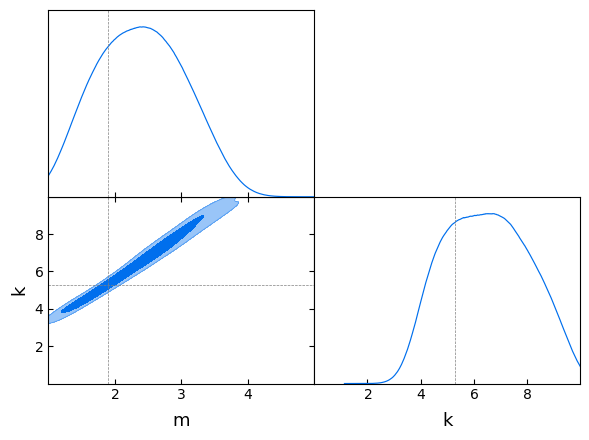

In [10]:
inferrer.plot_posterior(observed_data.flatten(), true_p, ["m", "k"], param_limits={"k": k_range, "m":m_range})

Not quite, but this isn't surprising since $k$ and $m$ are exactly degenerate in our model.  It has managed to learn that much -- see the diagonal line in the joint distribution.

# An anharmonic oscillator

Now let's see about inference of a damped non-linear model.
Instead of Hooke's law, assume a potential
\begin{equation}
    V(x) = \sum_{n=2}
\end{equation}
which results in equations of motion
\begin{equation}
    \frac{d^2x}{dt^2} = - \frac{1}{m} \left( \sum_{n=2} n k_n x^{n-2} - d \frac{dx}{dt} \right)
\end{equation}
where $d$ is a velocity dependent damping.

In [11]:
from harmonious_inference import PhysicsModelDetailed

nonlinear_model = PhysicsModelDetailed(x0_dist, v0_dist, t_eval, noise_amplitude)

Let's also define prior a prior for $k_2$.

In [12]:
d_range = (0, +1e+0)
k2_range = (-1e+1, +1e+1)
k3_range = (-1e-1, +1e-1)
k4_range = (+1e-9, +1e-2)  # ensure no divergence
nonlinear_prior = sbi.utils.BoxUniform(
    low=torch.tensor([m_range[0], d_range[0], k2_range[0], k3_range[0], k4_range[0]]),
    high=torch.tensor([m_range[1], d_range[1], k2_range[1], k3_range[1], k4_range[1]]),
)

Plotting the output of the model in phase space, we see that the ratio of the maximum postion and velocity depend on $k/m$.

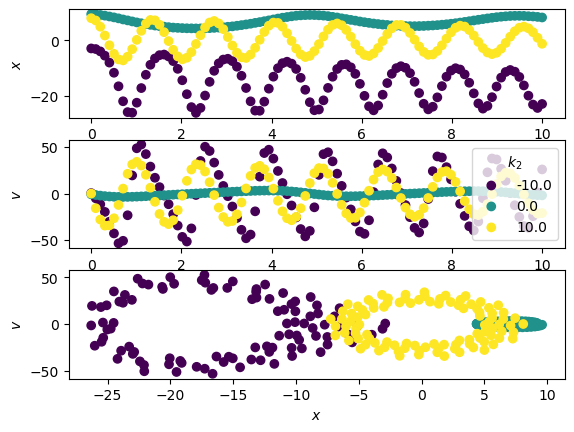

In [13]:
fig, [ax_x, ax_v, ax_p] = plt.subplots(3, 1)

ax_v.sharex(ax_x)
ax_p.sharey(ax_v)

for k2 in np.linspace(*k2_range, 3):
    d = nonlinear_model.forward_model(np.array([1, 1e-1, k2, k3_range[0], k4_range[1]]))

    ax_x.scatter(t_eval, d[0], c=[k2 for _ in d[0]], vmin=k2_range[0], vmax=k2_range[1], cmap=matplotlib.colormaps["viridis"], label=k2)
    ax_v.scatter(t_eval, d[1], c=[k2 for _ in d[0]], vmin=k2_range[0], vmax=k2_range[1], cmap=matplotlib.colormaps["viridis"], label=k2)
    ax_p.scatter(d[0], d[1], c=[k2 for _ in d[0]], vmin=k2_range[0], vmax=k2_range[1], cmap=matplotlib.colormaps["viridis"], label=k2)
    
ax_x.set_xlabel("$t$")
ax_x.set_ylabel("$x$")
ax_v.set_xlabel("$t$")
ax_v.set_ylabel("$v$")
ax_p.set_xlabel("$x$")
ax_p.set_ylabel("$v$")

ax_v.legend(title="$k_2$", loc="right")

### Inference of parameters

In [14]:
nonlinear_inferrer = harmonious_inference.Inferrer(t_eval, nonlinear_prior, nonlinear_model)

In [15]:
nonlinear_inferrer.train(num_simulations=10_000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 192 epochs.

Now let's pick values of $\mathbf{k}$ and $m$ from the prior and generate the corresponding observed timeseries.

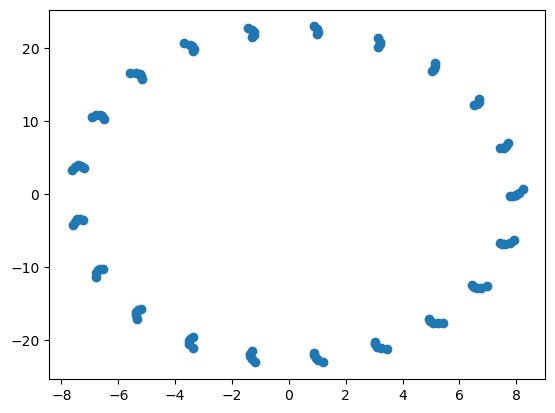

In [16]:
true_p = nonlinear_prior.sample()
observed_data = nonlinear_model.forward_model(true_p)

plt.scatter(observed_data[0], observed_data[1])

and see if we can infer $\mathbf{k}$ and $m$ from the data

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Removed no burn in


<Figure size 600x450 with 0 Axes>

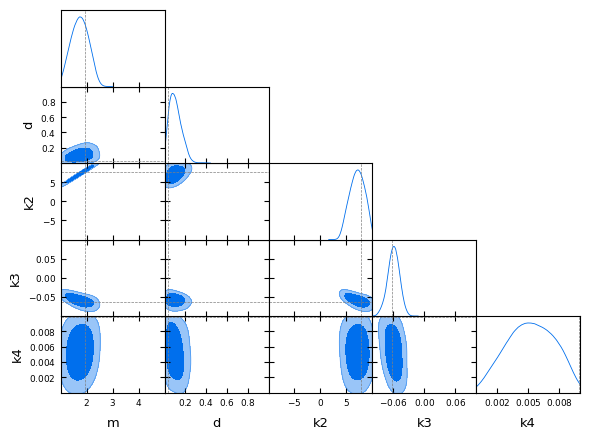

In [17]:
nonlinear_inferrer.plot_posterior(
    observed_data.flatten(),
    true_p,
    ["m", "d", *[f"k{i}" for i in range(2, 5)]],
    param_limits={
        "m": m_range,
        "d": d_range,
        "k2": k2_range,
        "k3": k3_range,
        "k4": k4_range,
    },
)

not too bad!